<a href="https://colab.research.google.com/github/JayantMiglani/Implementation-of-two-hidden-layers-neural-network-classifier-from-scratch-in-JAX/blob/main/Implementation_of_two_hidden_layers_neural_network_classifier_from_scratch_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of a two hidden layer neural network classifier in JAX  

# MLP TARINING ON MNIST



In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit,vmap,pmap,grad, value_and_grad

from torchvision.datasets import MNIST
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [3]:
## predict function
def MLP_predict(params,x):
  hidden_layers=params[:-1]

  activation=x
  for w,b in hidden_layers:
    activation= jax.nn.relu(jnp.dot(w,activation)+b)

  w_last, b_last= params[-1]
  logits=jnp.dot(w_last,activation)+b_last

  return logits - logsumexp(logits) # simply eqivalent to log(softmax) unit

dumm_img_flat= np.random.randn(np.prod(mnist_img_size))
print(dumm_img_flat.shape)

prediction= MLP_predict(MLP_params,dumm_img_flat)
print(prediction.shape)

batched_MLP_predict= vmap(MLP_predict,in_axes=(None,0))





(784,)
(10,)


In [4]:
## add data loading using Pytorch
def custom_transform(x):
   return np.ravel(np.array(x,dtype=np.float32)) #vectorize and return the PIL image transformed as numpy array


def custom_collate_fn(batch):
  transposed_data= list(zip(*batch))
  
  labels = np.array(transposed_data[1])
  imgs = np.stack(transposed_data[0])

  return imgs, labels

batch_size= 128

train_set= MNIST(root='train_mnist', download=True,train= True,transform=custom_transform) #my train_dataset is train_set
train_set_size=int(len(train_set)*0.8)
test_set_size= int(len(train_set)*0.2)
train_dataset, test_dataset = data.random_split(train_set, [train_set_size, test_set_size])

img= train_dataset[0][0]
print(img.shape)#--> vectorize the image

# add pytorch dataloader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

#Edit--> Optimization- loading the whole dataset into memory
# train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
# train_lbls = jnp.array(train_dataset.targets)

# test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
# test_lbls = jnp.array(test_dataset.targets)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

(784,)


In [5]:
# adding the training loop function

num_epochs=5
def loss_fn(params, imgs, gt_lbls):#gt->ground truth
  predictions =batched_MLP_predict(params,imgs) #expeected dimesnsion-(batch dimension,10)
  
  return -jnp.mean(predictions*gt_lbls)
  
### adding the accuracy metrics

def accuracy(params,loader):
  
  acc_sum=0 #acumulator
  for img,gt_classes in loader:
    pred_classes=jnp.argmax(batched_MLP_predict(params,imgs),axis=1)
    acc_sum+= np.sum(pred_classes==gt_classes)

  return acc_sum/(len(loader)*loader.batch_size)

# def accuracy(params, dataset_imgs, dataset_lbls):
#     pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
#     return jnp.mean(dataset_lbls == pred_classes)

@jit #jsut_in_time functionality of jax to speed up computations

def update(params,imgs,gt_lbls,lr=0.01): 
  loss,grads=value_and_grad(loss_fn)(params,imgs,gt_lbls) # will give gradients wrt the params in the pytree 
  
  return loss,jax.tree_multimap(lambda p,g:p-lr*g,params,grads)# sgd implementation using the pytree archtecture of the jax library



# to start with fresh parameter initialisation every time
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

loss_train=[]
loss_test=[]

for epoch in range(num_epochs):
  # adding data loading functionality
  for cnt,(imgs,lbls) in enumerate(train_loader):
   gt_labels=jax.nn.one_hot(lbls,len(MNIST.classes))
   loss,MLP_params=update(MLP_params,imgs,gt_labels)
   
   if cnt%50==0: #after every 50 samples,display the loss accumulated
        print(loss)

  print(f'Epoch {epoch}, train acc = {accuracy(MLP_params,train_loader)} test acc = {accuracy(MLP_params,test_loader)}')
  loss_train.append(1-(accuracy(MLP_params,train_loader)))
  loss_test.append(1-accuracy(MLP_params,test_loader))

0.241919
0.09882543
0.055881392
0.044986654
0.049155015
0.032198142
0.033093758
0.034528557
Epoch 0, train acc = 0.10197916626930237 test acc = 0.10013440996408463
0.021352565
0.022273753
0.0318239
0.023836983
0.026286913
0.047779456
0.019004688
0.026843382
Epoch 1, train acc = 0.10131249576807022 test acc = 0.09610214829444885
0.017478729
0.027947253
0.025153298
0.032956116
0.016324421
0.026627893
0.012645728
0.0126640275
Epoch 2, train acc = 0.10195833444595337 test acc = 0.09912634640932083
0.012569018
0.018617285
0.012086887
0.025513316
0.021605661
0.012178206
0.017893545
0.026131619
Epoch 3, train acc = 0.09849999845027924 test acc = 0.0984543040394783
0.021331323
0.012225411
0.01258844
0.014570472
0.019878784
0.013744391
0.021631116
0.0120925065
Epoch 4, train acc = 0.09687499701976776 test acc = 0.09576612710952759


**VISUALIZATIONS**

(28, 28)
prediction 8
true_label 8


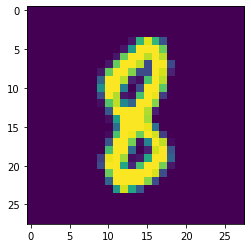

In [ ]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('prediction', pred)
print('true_label', gt_lbl)

plt.imshow(img); plt.show()

VISUALIZING MLP **WEIGHTS**

(512, 784)
(28, 28)


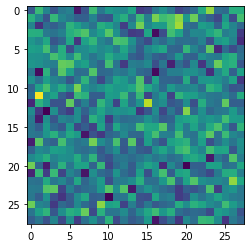

In [ ]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

Visualizing embeddings using t-SNE

(128, 256)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyError: ignored

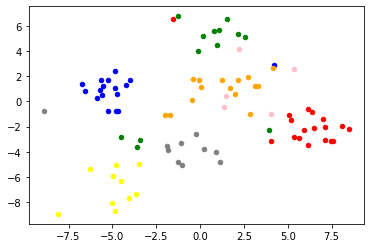

In [ ]:
from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()